In [13]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import collections
import datetime
pd.options.mode.chained_assignment = None

from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix

In [2]:
# Read in train and test data
test = pd.read_csv('Corona_NLP_test.csv')
train = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
full_data = train.append(test)
full_data.reset_index(drop=True, inplace=True)
full_data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
44950,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
44951,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
44952,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
44953,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [3]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
# Drop SreenName column since it does not contain relevant information
train.drop('ScreenName', inplace=True, axis=1)
test.drop('ScreenName', inplace=True, axis=1)

# Create datetime object
train['TweetAt'] = pd.to_datetime(train['TweetAt'])
test['TweetAt'] = pd.to_datetime(test['TweetAt'])


print(train.info())
print('----------------------------')
print(train.Sentiment.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   Location       32567 non-null  object        
 2   TweetAt        41157 non-null  datetime64[ns]
 3   OriginalTweet  41157 non-null  object        
 4   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.6+ MB
None
----------------------------
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64


In [5]:
# Preprocessing
def clean_data(x):
    x = re.sub(r'@\w+', '', x) # remove mentions
    x = re.sub(r'&\w+', '', x) # remove mentions
    x = x.translate(str.maketrans('', '', string.punctuation)) # remove punctuations
    x = x.translate(str.maketrans({'\r': '', '#': '', '\t': '', '\n': ''})) # replace tabs, new lines etc.
    x = re.sub(r'http\S+', '', x) # remove links
    return x

# Apply clae_data method
test['OriginalTweet'] = test['OriginalTweet'].apply(clean_data)
train['OriginalTweet'] = train['OriginalTweet'].apply(clean_data)

In [6]:
# Check out an examople
test['OriginalTweet'].iloc[0]

'TRENDING New Yorkers encounter empty supermarket shelves pictured Wegmans in Brooklyn soldout online grocers FoodKick MaxDelivery as coronavirusfearing shoppers stock up  '

In [7]:
# Create X_train
X_train = train['OriginalTweet']
y_train = train['Sentiment']
X_test = test['OriginalTweet']
y_test = test['Sentiment']

print('Train data samples:', X_train.shape)
print('Test data samples:', X_test.shape)

Train data samples: (41157,)
Test data samples: (3798,)


In [8]:
# Tokenizer
num_of_words = 10000
tk = Tokenizer(num_words=num_of_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=" ")

tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('Top 10 most common words are:', collections.Counter(tk.word_counts).most_common(10))

Fitted tokenizer on 41157 documents
Top 10 most common words are: [('the', 44436), ('to', 38270), ('and', 23872), ('of', 21494), ('a', 19216), ('in', 19019), ('coronavirus', 16532), ('covid19', 15651), ('for', 13969), ('is', 12195)]


In [9]:
# One hot encoding
def one_hot_encoder(seqs, nb_features = num_of_words):
    one_hot = np.zeros((len(seqs), nb_features))
    for idx, string in enumerate(seqs):
        one_hot[idx, string] = 1.
    return one_hot

X_train = one_hot_encoder(X_train_seq)
X_test = one_hot_encoder(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train[0]))
print('For this example we have {} features with a value of 1.'.format(X_train[0].sum()))

"[3, 3]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 1.0 features with a value of 1.


In [10]:
# Label encoding
label_enc = LabelEncoder()

y_train = label_enc.fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = label_enc.transform(y_test)
y_test = to_categorical(y_test)

# Train test split (setting 15 % of data for validation)
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train, y_train, test_size=0.15, 
                                                                random_state=42)

print('Shape of validation set:', X_valid.shape)

Shape of validation set: (6174, 10000)


In [11]:
# We can see that sentiment 'neutral' converted to an array of [0,0,0,1,0], 'positive' to an array of
# [0,0,0,0,1] and so on.
print(train['Sentiment'][:10])
print('')
print(y_train[:10])

0               Neutral
1              Positive
2              Positive
3              Positive
4    Extremely Negative
5              Positive
6              Positive
7               Neutral
8              Positive
9              Negative
Name: Sentiment, dtype: object

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [14]:
# Create the Deep Learning model with 3 fully-connected layers, added some Dropout layers (with 50% 
# dropout) to avoid overfitting. Use of L2 regularizers (also known as weight decay) slightly improves 
# accuracy and addresses  overfitting. The output layer has to have 5 nodes with a softmax activation 
# function to allow multiclass categorizing since we have 5 distinct categories. (Extr Pos, Pos. Neutral, 
# Neg, Extr Neg)

model = Sequential()
model.add(Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001), 
                    input_shape=(num_of_words,)))#input shape is equal to the num_of_words which is 10000
model.add(Dropout(0.5))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
# print out the model's structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 1,288,709
Trainable params: 1,288,709
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit on DL Model

# set Epoch and batch size
epochs = 10
batch_size = 256
# we can play around with optimizers both adam and rmsprop gives similar results (rmsprop is converging
# slowly but less likely to overfit). Use categorical crossentropy since we are dealing with multiclass
# labeling
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_rest, y_train_rest, epochs=epochs, batch_size=batch_size, verbose=1,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
137/137 [==============================] - 6s 43ms/step - loss: 1.5657 - accuracy: 0.3595 - val_loss: 1.2666 - val_accuracy: 0.5671
Epoch 2/10
137/137 [==============================] - 5s 35ms/step - loss: 1.2528 - accuracy: 0.5664 - val_loss: 1.1659 - val_accuracy: 0.6375
Epoch 3/10
137/137 [==============================] - 5s 34ms/step - loss: 1.1606 - accuracy: 0.6429 - val_loss: 1.1442 - val_accuracy: 0.6718
Epoch 4/10
137/137 [==============================] - 5s 34ms/step - loss: 1.1165 - accuracy: 0.6816 - val_loss: 1.1480 - val_accuracy: 0.6748
Epoch 5/10
137/137 [==============================] - 5s 35ms/step - loss: 1.0864 - accuracy: 0.7029 - val_loss: 1.1590 - val_accuracy: 0.6798
Epoch 6/10
137/137 [==============================] - 5s 33ms/step - loss: 1.0663 - accuracy: 0.7188 - val_loss: 1.1757 - val_accuracy: 0.6856
Epoch 7/10
137/137 [==============================] - 4s 32ms/step - loss: 1.0481 - accuracy: 0.7377 - val_loss: 1.1844 - val_accuracy: 0.6855

In [16]:
# Create a func to plot on different metrics
def evaluate_metrics(history, metric_name):
    
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    plt.plot(range(epochs), metric, 'r--', label='Train ' + metric_name)
    plt.plot(range(epochs), val_metric, 'g', label='Validation ' + metric_name)
    plt.title(metric_name)
    plt.legend()
    plt.show()

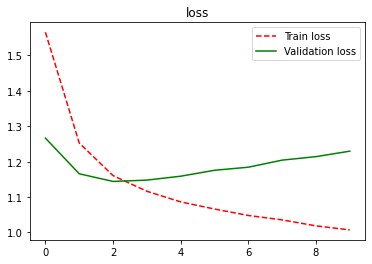

In [17]:
# Call the evaluate_metrics() func to plot loss function 
evaluate_metrics(history, 'loss')

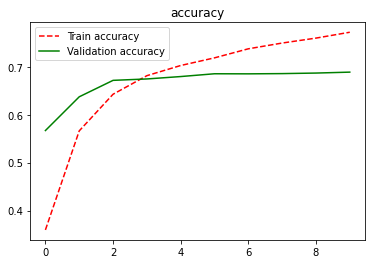

In [18]:
# Call the evaluate_metrics() func to plot accuracy function 
evaluate_metrics(history, 'accuracy')

In [19]:
# Create a dataframe from history
accuracies = pd.DataFrame(history.history)
accuracies.index.name = 'Epoch'
accuracies.index += 1
accuracies

,loss,accuracy,val_loss,val_accuracy
Epoch,,,,
1,1.565658,0.359517,1.266585,0.567055
2,1.252814,0.566361,1.165850,0.637512
3,1.160617,0.642855,1.144180,0.671850
4,1.116477,0.681617,1.147978,0.674765
5,1.086450,0.702856,1.158995,0.679786
6,1.066290,0.718835,1.175736,0.685617
7,1.048072,0.737730,1.184421,0.685455
8,1.035620,0.749764,1.204376,0.685941
9,1.018693,0.760083,1.214271,0.687075


In [20]:
# Evaluate on metrics
result = model.evaluate(X_test, y_test)
print('Loss: {}\nAccuracy: {}' .format(result[0], result[1]))

119/119 [==============================] - 1s 6ms/step - loss: 1.3456 - accuracy: 0.6364
Loss: 1.3456171751022339
Accuracy: 0.6363875865936279


In [21]:
# Make predictions
predictions = model.predict(X_test)
predictions = predictions > 0.5
predictions

array([[False, False,  True, False, False],
       [False, False, False, False,  True],
       [False,  True, False, False, False],
       ...,
       [False, False, False,  True, False],
       [ True, False, False, False, False],
       [False,  True, False, False, False]])

In [22]:
# Classififcation Report

print(classification_report(y_test, predictions, zero_division='warn'))
print('----------------------')
print('Confusion Matrix:')
print(confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1)))
print('----------------------')
print('Kappa_score: ', cohen_kappa_score(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.56      0.63       592
           1       0.79      0.61      0.69       599
           2       0.63      0.51      0.57      1041
           3       0.72      0.64      0.68       619
           4       0.61      0.59      0.60       947

   micro avg       0.68      0.58      0.62      3798
   macro avg       0.70      0.58      0.63      3798
weighted avg       0.68      0.58      0.62      3798
 samples avg       0.58      0.58      0.58      3798

----------------------
Confusion Matrix:
[[408   1 162   8  13]
 [ 51 364  14   7 163]
 [280  14 534  87 126]
 [108   3  57 399  52]
 [174  79  82  50 562]]
----------------------
Kappa_score:  0.49224700907788


C:\Users\user\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


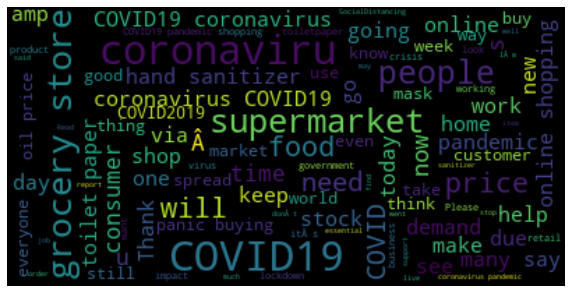

In [23]:
# Create a WORDCLOUD
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = train['OriginalTweet'].tolist() 
# join the list
text = ' '.join(text)
# create the wordcloud object
wordcloud = WordCloud(stopwords=set(STOPWORDS), collocations=True, max_font_size=30, 
                      max_words=100).generate(text)

# plot the wordloud object, representing the most frequently occuring words
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

(array([18262., 18322., 18383., 18444., 18506., 18567.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

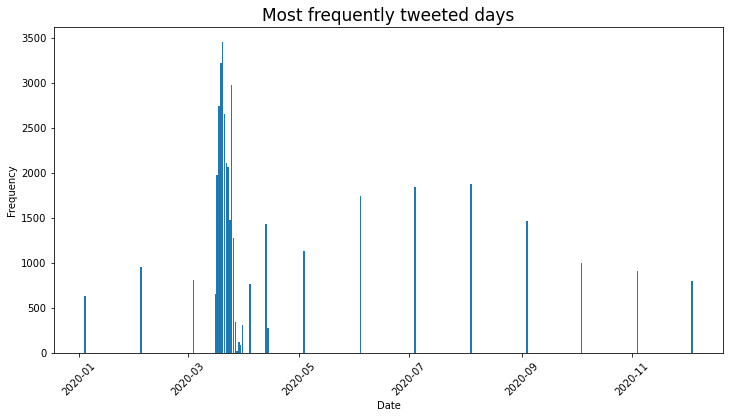

In [24]:
# Create a bar plot from the most frequently tweeted days to inspect if there is some distribution over 
# time
tweets_by_date = train['TweetAt'].value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.bar(tweets_by_date.index, height=tweets_by_date)
plt.title('Most frequently tweeted days', size = 17)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

In [25]:
# !pip install folium
# Install folium which allows us to visualize nice interactive Geo maps
# !pip install geopy
# Install geopy which is a popular geocoding web service
import folium
from geopy.geocoders import Nominatim
# geoapiExercises is a freely available open source user_agent to get data from geographical locations, so 
# let's create an object
geolocator = Nominatim(user_agent="geoapiExercises")

In [26]:
# The geocode method returns location related geo data
# Let's have a look an example
loc_data = geolocator.geocode("London, England")
print(loc_data.raw)
print('')
print('Latitude: {} and Longtitude: {}' .format(loc_data.raw['lat'], loc_data.raw['lon']))

{'place_id': 255515622, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 65606, 'boundingbox': ['51.2867601', '51.6918741', '-0.5103751', '0.3340155'], 'lat': '51.5073219', 'lon': '-0.1276474', 'display_name': 'London, Greater London, England, United Kingdom', 'class': 'boundary', 'type': 'administrative', 'importance': 1.0507827616237295, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//poi_boundary_administrative.p.20.png'}

Latitude: 51.5073219 and Longtitude: -0.1276474


In [27]:
# Reomve Null values
locations = full_data['Location'].dropna()
# Get top 300 rows the rest is pretty noisy
locations = locations.value_counts()[:300]
# Print out first 20 rows
print(locations[:20])

United States              603
London, England            568
London                     565
New York, NY               429
Washington, DC             411
United Kingdom             355
Los Angeles, CA            314
India                      283
UK                         246
USA                        243
Australia                  236
Canada                     220
England, United Kingdom    201
Toronto, Ontario           189
California, USA            179
San Francisco, CA          171
Chicago, IL                170
Global                     164
New York, USA              156
Boston, MA                 156
Name: Location, dtype: int64


In [28]:
# Prepare Latitude and Longtitude lists which are going to be used at folium map
latitude, longtitude = [], []

for location in locations.index:
    # Call the geocode func which's 'raw' method returns a dictionary with some Geo data
    try:
        loc_data = geolocator.geocode(location)
        # Grap its longtitude and Latitude keys
        latitude.append(loc_data.raw['lat'])
        longtitude.append(loc_data.raw['lon'])
    # If location is not found append 'None'
    except:
        latitude.append('None')
        longtitude.append('None')

# Delete 'None' items by indexes from either latitude, longtitude and locations series
idxs = [i for i, x in enumerate(latitude) if x == "None"]

latitude = [i for j, i in enumerate(latitude) if j not in idxs]
longtitude = [i for j, i in enumerate(longtitude) if j not in idxs]
locations = locations.drop(locations.index[idxs])

In [29]:
# Create a folium map (Circle())
m = folium.Map(location = [0, 0], zoom_start = 2, max_zoom = 6)
for i in range(len(locations)):
    folium.Circle(location = [latitude[i], longtitude[i]], radius = float(locations[i]*1000), color = 'blue',
                  tooltip = '<li><bold> Location : ' + str(locations.index[i]) + '<li><bold> Number of Tweets : ' 
                  + str(locations[i]),
                  fill = True, fill_color = 'purple').add_to(m)
m